# Loading libraries

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt

from pycaret import classification,regression

In [57]:
from core import AD, Cluster, MLModel, Visualization, MCAD
from data import Datasets, Preprocess, Features

# Getting dataset

In [5]:
datasets = Datasets()

In [6]:
datasets.info()

Database is 'starrydata(interpolated)'


In [7]:
datasets.get_versions()

['20220519',
 '20220228',
 '20220207',
 '20211124',
 '20210927',
 '20210611',
 '20210415',
 '20210216',
 '20210201',
 '20201222',
 '20201002',
 '20200818',
 '20200201',
 '20191119']

In [8]:
df_data_tmp = datasets.get_alldata(version="20210927")

datasets/
finished: datasets/interpolated_starrydata_20210927.csv


# Preprocessing data

In [11]:
preprocess = Preprocess()

In [12]:
filtercols = ["composition","published","Temperature","Seebeck coefficient","Electrical conductivity","Thermal conductivity","ZT"]

In [13]:
#Preprocess1: 
df_data = preprocess.get_dense(df_data_tmp,filtercols)

In [15]:
#Preprocess2: 
df_data["year"]=df_data["published"].apply(preprocess.getyear)

In [16]:
#Preprocess3: Unification of chemical composition
df_data["composition"] = df_data["composition"].apply(preprocess.set_reduce_formula)

In [17]:
#Preprocess4: Comparison of ZT calculated from S, σ, and κ with recorded ZT
df_data["ZTcalc"] = (((df_data["Seebeck coefficient"]**2)*df_data["Electrical conductivity"])/df_data["Thermal conductivity"])*df_data["Temperature"]
df_data["correlation"] = ((1-(np.abs((df_data["ZTcalc"]-df_data["ZT"])/df_data["ZT"]))).fillna(0) >= 0.95).astype(int)
df_data = df_data[df_data["correlation"]==1]

In [18]:
#Preprocess5: 
df_data = df_data[df_data["composition"]!=""]

In [19]:
df_data=df_data.reset_index(drop=True)

In [22]:
#Preprocess6:
df_data = df_data.dropna()

In [25]:
compT = []
for idx, comp in enumerate(df_data["composition"].values):
    compT.append(comp+"_"+str(df_data["Temperature"].values[idx]))

In [26]:
df_data["compositionT"] = compT

In [27]:
df_data["PF"] = (np.abs(df_data["Seebeck coefficient"])**2)*np.abs(df_data["Electrical conductivity"])*10**3
df_data["Seebeck coefficient"] = np.abs(df_data["Seebeck coefficient"]) * 10**6
df_data["Z"] = (df_data["ZT"] / df_data["Temperature"])*10**3

# Generating feature vectors

In [29]:
feature = Features()

In [30]:
complist = df_data["composition"]

In [32]:
df_feature = feature.get_comp_descfeatures(complist)#["Al3V","Si","CoSb3"]

# Preparation of training data

In [35]:
starrfiltercols = ["Temperature",
                     'Seebeck coefficient',
                     'Electrical conductivity',
                     'Thermal conductivity',
                     'Z',
                     'PF',
                     'composition',
                     'compositionT',
                     'year']

In [36]:
df_starry = preprocess.get_dense(df_data,starrfiltercols)

In [37]:
df_input = pd.concat([df_feature.iloc[:,1:], df_starry], axis=1).dropna()

# Splitting training data and test data

In [40]:
year_th = 2020

In [41]:
df_dataBF = df_input[df_input["year"]<=year_th].copy()

In [42]:
df_dataAF = df_input[df_input["year"]>year_th].copy()

In [43]:
df_dataAF = df_dataAF[df_dataAF["composition"].apply(preprocess.is_comp,df_compare=df_dataBF)]

# Applicability Doamin

In [45]:
ad = AD()

In [46]:
inputsize = 27

In [47]:
df_ad_train = df_dataBF.drop_duplicates("compositionT")
df_ad_train = df_ad_train.reset_index(drop=True)
df_ad_train = df_ad_train.iloc[:,:inputsize]

In [50]:
df_ad_test_tmp = df_dataAF.drop_duplicates("compositionT")
df_ad_test = df_ad_test_tmp.copy()
df_ad_test = df_ad_test.reset_index(drop=True)
df_ad_test = df_ad_test.iloc[:,:inputsize]

In [51]:
mcad = MCAD()

In [52]:
klist = range(1,26,1)

In [110]:
results = mcad.mcad(df_ad_train,klist,iternum=1000, n_workers=3)

100%|██████████| 1000/1000 [10:04:05<00:00, 36.25s/it] 


In [111]:
viz = Visualization()

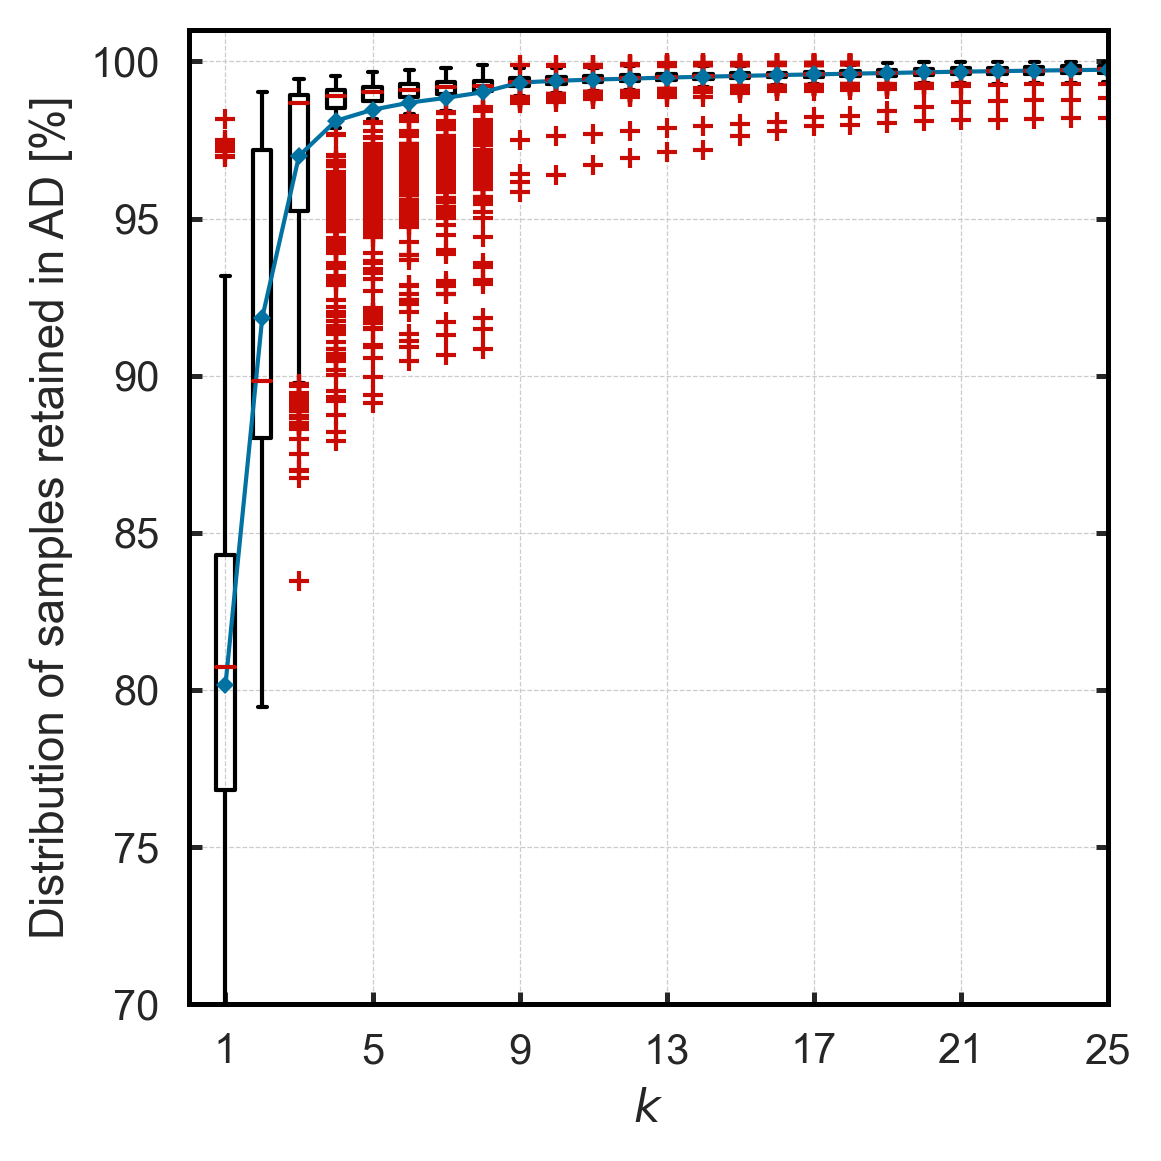

In [112]:
viz.show_mcad(results, klist)